# Imports

In [ ]:
!pip install tensorflow_addons node2vec networkx -q
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow import one_hot

from tensorflow_addons.metrics import F1Score

from gensim.models import Word2Vec
from node2vec import Node2Vec
import networkx as nx

# Reading Data

In [ ]:
def convert_to_embeddings(emb):
   return np.array([ [float(j) for j in i.strip().split()] for i in emb[1:-1].split('\n') ]).reshape(-1)

In [ ]:
labelled_cleaned = pd.read_csv('labelled_cleaned.csv')
labelled_cleaned.drop(['Unnamed: 0'], inplace=True, axis=1)
labelled_embeddings = [i for i in np.load('labelled_embeddings.npy')]
labelled_cleaned['embeddings'] = [i for i in labelled_embeddings]

In [ ]:
unlabelled_cleaned = pd.read_csv('unlabelled_cleaned.csv')
unlabelled_cleaned.drop(['Unnamed: 0'], inplace=True, axis=1)
unlabelled_embeddings = [i for i in np.load('unlabelled_embeddings_2k.npy')]
unlabelled_cleaned['embeddings'] = [i for i in unlabelled_embeddings]

# Generate graph and node embeddings

In [ ]:
def make_graph(data, cos_sim=0.9, plot_graph=False):
    edges_subset=list(combinations(data.index, 2))
    edge_sim_labelled=[]

    for idx1, idx2 in tqdm(edges_subset):

        cosine_sim_val=cosine_similarity( [ data['embeddings'][idx1] ], [ data['embeddings'][idx2] ])

        if cosine_sim_val>cos_sim:
            edge_sim_labelled.append([idx1, idx2])
    
    G = nx.Graph()
    G.add_nodes_from(data.index)
    G.add_edges_from(edge_sim_labelled)

    if plot_graph:
        plt.figure(figsize=(20,20))
        nx.draw(G)
    return G

In [ ]:
def make_N2V_embeddings(G, cos_sim=0.9, embedding_size=512, walk_length=10, num_walks=80, window=10, connect_type='sim_country_year'):
    filename=f"emb{embedding_size}_wklen{walk_length}_nwalk{num_walks}_win{window}_{connect_type}"
    if connect_type.find('sim'):
        filename+=f"_csim{cos_sim}"
    filename+=f'_GLen{len(G.nodes)}'
    node2vec = Node2Vec(G, dimensions=embedding_size, walk_length=walk_length,num_walks=num_walks, workers=4)
    node2vec_model = node2vec.fit(window=window, min_count=1,batch_words=4)

    embeddings_map = node2vec_model.wv
    embeddings = embeddings_map[[i for i in range(len(G.nodes))]]

    node2vec_model.save(filename+'.model')

    return embeddings

In [ ]:
def load_N2V_embeddings(G_len, embedding_path='/content/drive/MyDrive/Dataset/UNGDC/emb512_wklen30_nwalk160_win20_cossim0.9_sim.model'):
    node2vec_model=Word2Vec.load(embedding_path)
    embeddings = node2vec_model.wv[[i for i in range(G_len)]]
    return embeddings

In [ ]:
embedding_size=512
walk_length=30
num_walks=160
window=20
connect_type='sim'
G=make_graph(labelled_cleaned, cos_sim=0.9, plot_graph=False)
embeddings=make_N2V_embeddings(G, embedding_size=embedding_size, walk_length=walk_length, num_walks=num_walks, window=window, connect_type=connect_type)

100%|██████████| 3507276/3507276 [22:38<00:00, 2581.93it/s]


Computing transition probabilities:   0%|          | 0/2649 [00:00<?, ?it/s]

In [ ]:
embeddings=load_N2V_embeddings(2649, 'emb512_wklen30_nwalk160_win20_sim_GLen2649.model')

In [ ]:
labels={'security': 0, 
        'greeting': 1, 
        'development': 2, 
        'democracy': 3, 
        'human': 4, 
        'un': 5}

train_labels_one_hot=one_hot(
    [ labels[i] for i in labelled_cleaned['coding'].values ],
    len(labels)).numpy()

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(embeddings, train_labels_one_hot)

# Neural Net

In [ ]:
class Classifier(Model):
    def __init__(self, hidden_dims, output_size, dropout_rate):
        super(Classifier, self).__init__()
        self.dense1 = Dense(hidden_dims[0], activation='relu')
        self.dense2 = Dense(hidden_dims[1], activation='relu')
        self.dense3 = Dense(output_size, activation='softmax')
        self.bnorm1 = BatchNormalization()
        self.bnorm2 = BatchNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.bnorm1(x)
        
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.bnorm2(x)
        
        output = self.dense3(x)
        return output

In [ ]:
tf_model = Classifier((256, 128), len(labels), 0.3)
tf_model.build(input_shape=(None, embedding_size))
tf_model.compile(optimizer=Adagrad(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[F1Score(num_classes=len(labels))])
tf_model.summary()

Model: "classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  131328    
                                                                 
 dense_4 (Dense)             multiple                  32896     
                                                                 
 dense_5 (Dense)             multiple                  774       
                                                                 
 batch_normalization_2 (Batc  multiple                 1024      
 hNormalization)                                                 
                                                                 
 batch_normalization_3 (Batc  multiple                 512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         multiple                 

In [ ]:
his = tf_model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=400, verbose=1, 
                           callbacks = EarlyStopping(monitor='loss', patience=10))

Epoch 1/400
63/63 [==============================] - 4s 39ms/step - loss: 2.0798 - f1_score: 0.1371 - val_loss: 1.7540 - val_f1_score: 0.0485
Epoch 2/400
63/63 [==============================] - 1s 14ms/step - loss: 1.9317 - f1_score: 0.1601 - val_loss: 1.7310 - val_f1_score: 0.0484
Epoch 3/400
63/63 [==============================] - 1s 9ms/step - loss: 1.8925 - f1_score: 0.1685 - val_loss: 1.7274 - val_f1_score: 0.0484
Epoch 4/400
63/63 [==============================] - 0s 7ms/step - loss: 1.8516 - f1_score: 0.1837 - val_loss: 1.7251 - val_f1_score: 0.0499
Epoch 5/400
63/63 [==============================] - 0s 6ms/step - loss: 1.8408 - f1_score: 0.1803 - val_loss: 1.7321 - val_f1_score: 0.0499
Epoch 6/400
63/63 [==============================] - 0s 7ms/step - loss: 1.8374 - f1_score: 0.1731 - val_loss: 1.7383 - val_f1_score: 0.0499
Epoch 7/400
63/63 [==============================] - 0s 7ms/step - loss: 1.8207 - f1_score: 0.1887 - val_loss: 1.7480 - val_f1_score: 0.0496
Epoch 8/400

In [ ]:
tf_model.evaluate(x=X_train, y=y_train)

63/63 [==============================] - 0s 3ms/step - loss: 1.5089 - f1_score: 0.1271


[1.508922815322876,
 array([0.5857404 , 0.        , 0.03266788, 0.        , 0.        ,
        0.144     ], dtype=float32)]

In [ ]:
tf_model.evaluate(x=X_eval, y=y_eval)

21/21 [==============================] - 0s 4ms/step - loss: 1.6138 - f1_score: 0.1121


[1.613793969154358,
 array([0.58106637, 0.        , 0.01123595, 0.        , 0.        ,
        0.08      ], dtype=float32)]

In [ ]:
tf_model.save_weights('graph_approach')

In [ ]:
train_loss = his.history['loss']
eval_loss = his.history['val_loss']
train_f1 = his.history['f1_score']
eval_f1 = his.history['val_f1_score']

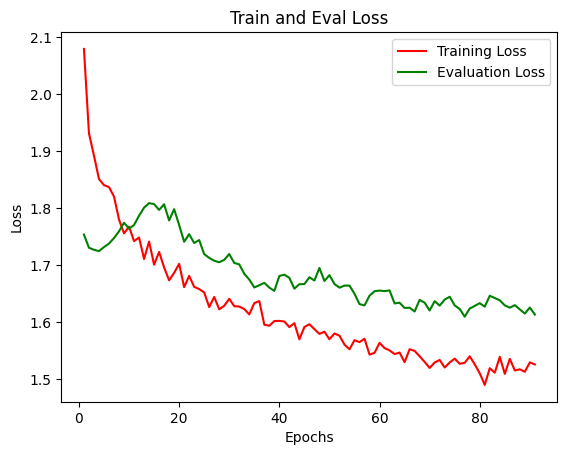

In [ ]:
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training Loss')
plt.plot(range(1, len(train_loss)+1), eval_loss, 'g', label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Eval Loss')
plt.show()

In [ ]:
train_f1=[sum(i)/len(train_f1) for i in train_f1]
eval_f1=[sum(i)/len(eval_f1) for i in eval_f1]

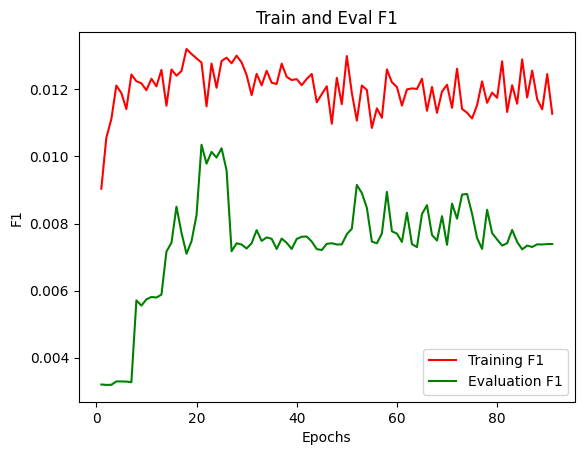

In [ ]:
plt.plot(range(1, len(train_loss)+1), train_f1, 'r', label='Training F1')
plt.plot(range(1, len(train_loss)+1), eval_f1, 'g', label='Evaluation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.title('Train and Eval F1')
plt.show()